# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import plotly.express as px
import torch

import sys
sys.path.append("../../..")
from src.models import training_utils,base_model

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/"
experiments_folder = "../../../data/experiments/design_space_merged_experiment/seed_0/"

# Load a pretrained model

In [9]:
results = pd.read_parquet(experiments_folder+"experiment_16_06_23__17_59_43.parquet")

node_csv = pd.read_csv(data_folder+"merged_nodes.csv")
node_info = pd.read_csv(data_folder+"merged_node_info.csv")
edge_data = pd.read_csv(data_folder+"merged_edges.csv")

datasets, node_map = training_utils.load_data(data_folder+"split_dataset/seed_0/")
train_data, val_data = datasets

In [4]:
def get_tensor_index_df(node_data, node_map, node_info):
    sub_dfs = []
    for node_type in node_map.keys():
        sub_df = node_data[node_data.node_type == node_type]
        node_map_series = pd.Series(node_map[node_type], name="tensor_index")
        sub_df = sub_df.merge(node_map_series, left_on="node_index", right_index=True,
                              how="right").sort_values(by="tensor_index").reset_index()

        sub_dfs.append(sub_df)
    tensor_df = pd.concat(sub_dfs, ignore_index=True)
    df = pd.merge(tensor_df, node_info[["node_index", "comunidades_infomap", "comunidades_louvain",
                  "degree_gda", "degree_pp", "degree_dd"]], on="node_index")
    df["total_degree"] = df.degree_pp + df.degree_gda + df.degree_dd
    return df

In [5]:
df = get_tensor_index_df(node_csv,node_map,node_info).set_index("node_index")

In [10]:
results.sort_values(by="auc",ascending=False)

,L2_norm,batch_norm,conv_type,delta,dropout,epochs,experiment_name,feature_dim,feature_type,heads,...,micro_aggregation,msg_passing_layers,normalize_output,patience,post_process_layers,pre_process_layers,supervision_types,weight_decay,auc,curve_data
62,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909951,"[[0.703677773475647, 0.6893664002418518, 0.676..."
55,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909892,"[[0.6917510628700256, 0.6621622443199158, 0.63..."
54,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909118,"[[0.6860914826393127, 0.6716712117195129, 0.65..."
59,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909058,"[[0.6657952666282654, 0.6534611582756042, 0.64..."
9,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.908880,"[[0.6850339770317078, 0.6739553809165955, 0.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.821747,"[[0.691173255443573, 0.6777836084365845, 0.665..."
17,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.816867,"[[0.7043997645378113, 0.6885340809822083, 0.67..."
14,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.815617,"[[0.6883745789527893, 0.6758227944374084, 0.66..."
35,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.797107,"[[0.6960344910621643, 0.6834494471549988, 0.67..."


In [11]:
def load_model(weights_path,supervision_types,metadata,model_args=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = torch.load(weights_path,map_location=torch.device(device))

    model = base_model.base_model(model_args,metadata,supervision_types)
    model.load_state_dict(weights)
    
    return model

In [12]:
model_params = ['hidden_channels', 'conv_type', 'batch_norm', 'dropout', 'micro_aggregation', 'macro_aggregation', 'layer_connectivity', 'L2_norm', 'pre_process_layers', 'msg_passing_layers', 'post_process_layers', 'normalize_output', 'jumping_knowledge']
eid = 62
params = results[model_params].loc[eid].to_dict()
weights_path = experiments_folder+"model_62_16_06_23__17_59_43.pth"

model = load_model(weights_path,[("gene_protein","gda","disease")],train_data.metadata(),params)

# Get encodings

In [13]:
feature_type = results.loc[eid,"feature_type"]
feature_dim  = results.loc[eid,"feature_dim"]
val_data = training_utils.initialize_features(val_data, feature_type, feature_dim)

In [14]:
encodings = training_utils.get_encodings(model,val_data)

# Prioritize

In [15]:
class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,apply_sigmoid=True):
        pred = (x_source * x_target).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

In [16]:
def prioritize(node_index,encodings_dict,node_df):
    assert df.index.name == "node_index", f"df index must be node_index, not {df.index.name}."

    decoder = inner_product_decoder()
    source_type = node_df.loc[node_index,"node_type"]
    tensor_index = node_df.loc[node_index,"tensor_index"]

    if source_type == "disease":
        target_type = "gene_protein"

    elif source_type == "gene_protein":
        target_type = "disease"

    source_vector = encodings_dict[source_type][tensor_index]
    target_matrix = encodings_dict[target_type]

    predicted_edges = decoder(target_matrix,source_vector)
    ranked_scores, ranked_indices = torch.sort(predicted_edges,descending=True)
    results = pd.DataFrame({"score":ranked_scores.cpu().numpy(),"tensor_index":ranked_indices.cpu().numpy()})
    results.score = results.score.round(3)

    index_map = df.loc[df.node_type == target_type,["tensor_index","node_name"]].reset_index()
    ranked_predictions = pd.merge(results,index_map,on="tensor_index")
    ranked_predictions.index.name = "rank"

    return ranked_predictions

In [17]:
df.sort_values(by="degree_gda",ascending=False)[200:]

,index,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,,
2816,17026,1437,CSF2,gene_protein,disgenet,9910,NaN,NaN,103.0,9.0,0.0,112.0
10356,24222,5173,PDYN,gene_protein,disgenet,13213,NaN,NaN,102.0,8.0,0.0,110.0
23153,5100,C0270844,Tonic Seizures,disease,disgenet,1138,NaN,NaN,102.0,0.0,0.0,102.0
21138,4895,C0043094,Weight Gain,disease,disgenet,1028,NaN,NaN,102.0,0.0,0.0,102.0
24070,752,C0346647,Malignant neoplasm of pancreas,disease,disgenet,264,24.0,3.0,102.0,0.0,6.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7973,26157,3681,ITAD,gene_protein,hippie,14262,NaN,NaN,0.0,5.0,0.0,5.0
14488,26152,729085,F198A,gene_protein,hippie,14257,NaN,NaN,0.0,1.0,0.0,1.0
13450,26148,645922,S1A7B,gene_protein,hippie,14253,NaN,NaN,0.0,2.0,0.0,2.0


In [18]:
node_index = 24070
predictions = prioritize(node_index,encodings,df)

seguir viendo este mapeo si estaba bien, poner un print de nombres de nodos y eso

In [19]:
predictions

,score,tensor_index,node_index,node_name
rank,,,,
0,0.997,7106,10484,PIK3CA
1,0.997,10921,10517,PLAT
2,0.997,425,7360,HRAS
3,0.997,5669,12696,BCHE
4,0.997,1558,4623,FGFR2
...,...,...,...,...
17738,0.101,3412,36618,U2AF1/U2AF2
17739,0.100,7419,6901,PP13
17740,0.100,5950,36501,DNA polymerase delta


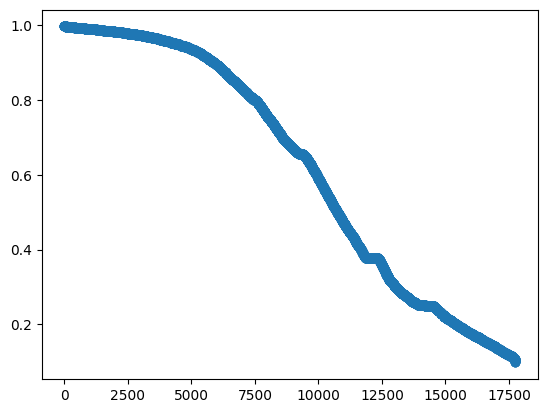

In [20]:
plt.scatter(predictions.index,predictions.score)

In [21]:
node_type = node_csv.loc[node_index,"node_type"]
y_type = "disease" if node_type == "gene_protein" else "gene_protein"
existing_edges = edge_data.loc[(edge_data.x_index == node_index) & (edge_data.y_type == y_type),"y_index"].values
filtered_predictions = predictions.reset_index().set_index("node_index").loc[existing_edges].sort_values(by="rank")
filtered_predictions

,rank,score,tensor_index,node_name
node_index,,,,
8204,8,0.997,3622,KRAS
13968,10,0.997,3155,STAT3
7678,12,0.997,14368,IFNA2
539,14,0.997,1302,CDKN2A
10518,20,0.997,15031,PLAU
...,...,...,...,...
7683,6282,0.878,9252,IFNA5
1914,6879,0.839,8712,CLPTM1
1356,7106,0.824,7581,ANXA10


In [22]:
top_100_pred = predictions[:100].node_index.values
len(set(top_100_pred).intersection(set(existing_edges)))

17

# Veo qué enlaces quedaron en cada split

In [23]:
def tensor_to_edgelist(tensor: torch.tensor):
    sources = tensor[0,:].tolist()
    targets = tensor[1,:].tolist()
    edgelist = list(zip(sources,targets))
    return edgelist

def reverse_map(node_map,edge_list,edge_type):
    """Maps edge dictionary from pyg Heterodata back into the original node indexes from the dataframe"""
    src_map = {v:k for k,v in node_map[edge_type[0]].items()}
    dst_map = {v:k for k,v in node_map[edge_type[2]].items()}
    mapped_edge_list = [(src_map[n1],dst_map[n2]) for (n1,n2) in edge_list]

    return mapped_edge_list

def inverse_map_heterodata(data,node_map):
    """Maps full edge data from pyg Heterodata back into the original node indexes from the dataframe"""
    edge_dict = {}
    for edge_type in data.edge_types:
        type_dict = {}
        edge_tensor = data[edge_type]["edge_index"]
        edge_list = tensor_to_edgelist(edge_tensor)
        mapped_edge_list = reverse_map(node_map,edge_list,edge_type)

        type_dict["message_passing_edges"] = mapped_edge_list

        if "edge_label_index" in data[edge_type].keys():
            labeled_edges_tensor = data[edge_type]["edge_label_index"]
            labeled_edges_list = tensor_to_edgelist(labeled_edges_tensor)
            mapped_labeled_edges_list = reverse_map(node_map,labeled_edges_list,edge_type)

            edge_labels = data[edge_type]["edge_label"].tolist()

            type_dict["supervision_edges"] = mapped_labeled_edges_list
            type_dict["supervision_labels"] = edge_labels
 
        edge_dict[edge_type] = type_dict
    
    return edge_dict

def edge_map_to_df(inverse_map_dict):
    edges_df = {}
    for edge_type,sub_dict in inverse_map_dict.items():
        if "supervision_edges" in sub_dict.keys():
            edges = pd.DataFrame(sub_dict["supervision_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})
            edge_labels_df = pd.concat([edges,pd.DataFrame(sub_dict["supervision_labels"])],axis=1).rename(columns={0:"label"})

            msg_passing_edges_df = pd.DataFrame(sub_dict["message_passing_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})

            edges_df[edge_type] = {"supervision_edges":edge_labels_df,"message_passing_edges":msg_passing_edges_df}
    
    return edges_df

In [24]:
validation_edges = inverse_map_heterodata(val_data,node_map)
train_edges = inverse_map_heterodata(train_data,node_map)

Verifico que son los mismos enlaces

In [25]:
edge_list = validation_edges[("gene_protein","gda","disease")]["message_passing_edges"]
gene_to_disease = [(b,a) for (a,b) in edge_list]
disease_to_gene = validation_edges[("disease","gda","gene_protein")]["message_passing_edges"]

len(set(gene_to_disease)&set(disease_to_gene)) == len(gene_to_disease)

True

In [26]:
dataset = train_data

mapped_dataset = inverse_map_heterodata(train_data,node_map)
df_dataset = edge_map_to_df(mapped_dataset)

supervision_edges = df_dataset[("gene_protein","gda","disease")]["supervision_edges"]
node_supervision_edges = supervision_edges[supervision_edges.disease == node_index]

msg_edges = df_dataset[("gene_protein","gda","disease")]["message_passing_edges"]
node_msg_edges = msg_edges[msg_edges.disease == node_index]

In [28]:
node_msg_edges

,gene_protein,disease
13166,9418,24070
13167,14317,24070
13168,18421,24070
13169,4193,24070
13170,3958,24070
...,...,...
13230,10518,24070
13231,8698,24070
13232,10723,24070
13233,14028,24070


In [29]:
node_supervision_edges

,gene_protein,disease,label
967,13142,24070,1.0
1015,7205,24070,1.0
1087,10841,24070,1.0
1986,10553,24070,1.0
2346,16191,24070,1.0
2665,13851,24070,1.0
3679,13948,24070,1.0
5995,15256,24070,1.0
6215,14290,24070,1.0
6927,17031,24070,1.0


In [30]:
predictions.reset_index().set_index("node_index").loc[node_supervision_edges.gene_protein.values].sort_values(by="rank")

,rank,score,tensor_index,node_name
node_index,,,,
8204,8,0.997,3622,KRAS
7205,29,0.997,482,HIF1A
14290,39,0.997,3684,TNF
13851,97,0.996,12419,SOD2
10841,100,0.996,1249,PPARG
8854,218,0.996,2015,SMAD4
2182,228,0.996,9070,CNR1
4287,298,0.995,2564,AKT2
13948,367,0.995,14455,SST


In [31]:
labels = train_edges[("gene_protein","gda","disease")]["supervision_labels"]

In [32]:
sum(np.array(labels) == 0) == len(labels)/2

True

# Proporción de samples positivas y negativas

Cuantas enfermedades aparecen en supervisión en total

In [33]:
# cuantas enf aparecen en supervisión
len(supervision_edges.disease.unique())

10794

Cuantas enfermedades aparecen en supervisión con samples positivas

In [34]:
len(supervision_edges[supervision_edges.label == 1].disease.unique())

3928

Cuantas enfermedades aparecen en supervisión con samples negativas

In [35]:
len(supervision_edges[supervision_edges.label == 0].disease.unique())

9117

plotear vs grado

In [36]:
supervision_edges

,gene_protein,disease,label
0,447,26091,1.0
1,10501,31267,1.0
2,7965,32060,1.0
3,15907,19957,1.0
4,8518,21297,1.0
...,...,...,...
26879,15601,19829,0.0
26880,15350,28847,0.0
26881,8946,32972,0.0
26882,3864,28468,0.0


In [37]:
import plotly.express as px
fig = px.histogram(supervision_edges[supervision_edges.label == 1].disease.value_counts(),width=800, height=400)
fig.show()

In [38]:
fig = px.histogram(supervision_edges[supervision_edges.label == 0].disease.value_counts(),width=800, height=400)
fig.show()

In [39]:
frec_negativa = supervision_edges[supervision_edges.label==0].disease.value_counts()
frec_positiva = supervision_edges[supervision_edges.label == 1].disease.value_counts()

In [40]:
frec_negativa_df = pd.merge(frec_negativa, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_negativa"})

frec_positiva_df = pd.merge(frec_positiva, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_positiva"})
frec_positiva_df

,frec_positiva,degree_gda
18773,171,1074.0
20754,149,883.0
18978,113,702.0
19957,111,774.0
24165,108,616.0
...,...,...
33500,1,1.0
27115,1,7.0
23511,1,1.0
22899,1,4.0


In [41]:
fig = px.scatter(frec_negativa_df,"frec_negativa","degree_gda")
fig.show()

In [435]:
fig = px.scatter(frec_positiva_df,"frec_positiva","degree_gda")
fig.show()

In [468]:
from torch_geometric.utils.negative_sampling import edge_index_to_vector

# edge_index = train_data.edge_index_dict[("gene_protein","gda","disease")]
edge_index = train_data.edge_index_dict[("gene_protein","ppi","gene_protein")]
size = edge_index.size()


In [469]:
idx, population = edge_index_to_vector(edge_index,size,True,True)

In [471]:
from torch_geometric.utils import negative_sampling

negative_sampling()